In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns

In [3]:
# Load data from Google Drive
df_A = pd.read_csv('C:/SEAN/GA Tech Academics/Grad/Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Stress/Datasets/F_Relax_A_feature.csv', header=0)
df_M = pd.read_csv('C:/SEAN/GA Tech Academics/Grad/Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Stress/Datasets/F_Relax_M_feature.csv', header=0)
df_S = pd.read_csv('C:/SEAN/GA Tech Academics/Grad/Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Stress/Datasets/F_Relax_S_feature.csv', header=0)

In [4]:
# Fill missing values with the mode
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])

In [5]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 450)
(6000, 450)
(6000, 450)


In [6]:
# Drop the first column
df_A = df_A.iloc[:, 1:]
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]

In [7]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 449)
(6000, 449)
(6000, 449)


In [25]:
# Perform feature selection and dimensionality reduction
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float):
    y = df.iloc[:, -1]  # Target variable is the last column
    kept_columns_rfe = []  # List to store selected features
    start_column_index = 0

    for i in range(32):
        # Selecting features, excluding ratios (e.g., theta-beta ratio)
        X = df.iloc[:, list(range(start_column_index, start_column_index + 5)) + list(range(start_column_index + 8, start_column_index + 14))]
        curr_columns = X.columns

        # Recursive Feature Elimination with Cross Validation (RFECV)
        rfecv = RFECV(estimator=LogisticRegression(max_iter=10000), min_features_to_select=1, cv=StratifiedKFold(), scoring='accuracy')
        rfecv.fit(X, y)

        # Track the kept features
        kept_columns_rfe.extend(curr_columns[rfecv.support_])
        start_column_index += 14

    # After RFE, get the remaining features
    df_after_rfe = df[kept_columns_rfe]
    X = df_after_rfe
    
    # Scaling and PCA for dimensionality reduction
    scaler = StandardScaler()  # Scale the features
    scaled_X = scaler.fit_transform(X)

    # Reduce to a certain percentage of explained variance (e.g., 80%)
    pca = PCA(n_components=50)  # Adjust as needed
    pca_result = pca.fit_transform(scaled_X)

    # CODE I ADDED
    
    # Determine number of components needed to keep a certain threshold percentage of variance

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    num_pc = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    print("Number of principal components to keep", variance_threshold * 100, "% of variance:", num_pc)

    # Visualization
    plt.figure(figsize=(8, 6))

    # Line plot for cumulative explained variance (all points are initially red)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='red', label='Cumulative explained variance', linestyle='-')

    # Use blue dots to denote every n-th point where n is divisible by 5
    for i in range(5, len(cumulative_variance_ratio) + 1, 5):
        plt.scatter(i, cumulative_variance_ratio[i - 1], color='blue', zorder=5) 
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xlabel('# of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.show()
    
    # Find components that give the variance threshold.
    
    components_for_threshold = np.where(cumulative_variance_ratio >= variance_threshold)[0][0] + 1

    # Get the list of column names needed to reach the variance threshold.
    needed_columns = kept_columns_rfe[:components_for_threshold]
    print("final kept columns:")
    print(df[needed_columns].head())
    print("----------FINISHED FEATURE SELECTION----------")
    return df[needed_columns]
    
    #return pca_result, y  



Number of principal components to keep 80.0 % of variance: 45


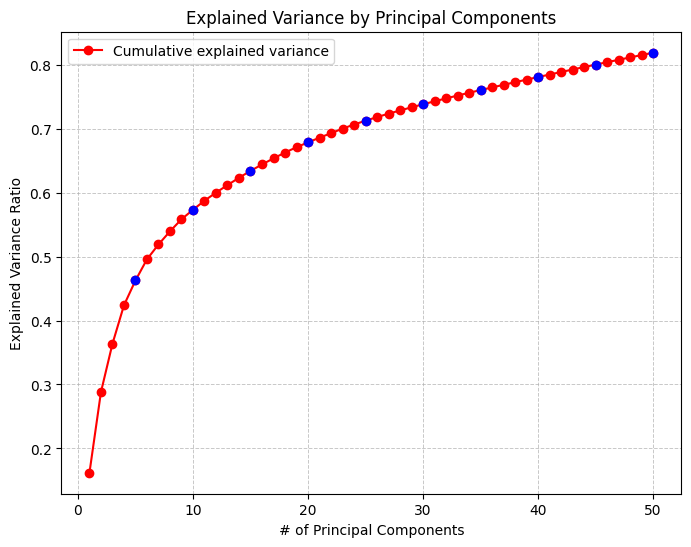

final kept columns:
    0.psd_delta   0.psd_theta  0.psd_alpha   0.psd_beta  0.psd_gamma  \
0  14850.830823  14923.215094  7910.065985  6950.560915  3047.582095   
1  14838.280527  18650.065251  7921.853628  8087.625726  2855.607519   
2   7143.715839  16263.647994  6245.775968  4200.151132  2838.155117   
3   7143.570136  12413.634950  7677.763201  4200.428316  2764.924613   
4  19573.432251  18451.900407  7663.019348  6509.398324  2423.619039   

   0.spectral_entropy_value  0.sample_entropy_value  0.delta_rel_power  \
0                  4.911304                2.639057           0.059237   
1                  4.778889                1.098612           0.150847   
2                  4.455605                0.000000           0.082685   
3                  4.594508                0.000000           0.032636   
4                  4.605586                1.386294           0.198891   

   0.theta_rel_power  0.alpha_rel_power  ...  3.alpha_rel_power  \
0           0.199444           0.18

In [29]:
# Apply feature selection and dimensionality reduction to the datasets
df_A_preprocessed = perform_feature_selection(df_A, variance_threshold=0.8)

In [30]:
df_A_y = df_A.iloc[:, -1]
df_A_preprocessed = pd.concat([df_A_preprocessed, df_A_y], axis=1)
df_A_preprocessed.head()

,0.psd_delta,0.psd_theta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.spectral_entropy_value,0.sample_entropy_value,0.delta_rel_power,0.theta_rel_power,0.alpha_rel_power,...,3.beta_rel_power,4.psd_theta,4.psd_beta,4.spectral_entropy_value,4.sample_entropy_value,4.delta_rel_power,4.theta_rel_power,4.alpha_rel_power,4.beta_rel_power,Stress_level
0,14850.830823,14923.215094,7910.065985,6950.560915,3047.582095,4.911304,2.639057,0.059237,0.199444,0.183638,...,0.310750,16679.797843,5473.184804,4.805409,2.014903,0.068170,0.232666,0.112502,0.281509,1
1,14838.280527,18650.065251,7921.853628,8087.625726,2855.607519,4.778889,1.098612,0.150847,0.134471,0.107598,...,0.399740,16729.087706,7251.832429,4.661888,1.098612,0.119489,0.165455,0.087223,0.369785,1
2,7143.715839,16263.647994,6245.775968,4200.151132,2838.155117,4.455605,0.000000,0.082685,0.319816,0.088251,...,0.244573,11389.834726,4200.371424,4.683229,0.000000,0.074630,0.269666,0.094046,0.221411,1
3,7143.570136,12413.634950,7677.763201,4200.428316,2764.924613,4.594508,0.000000,0.032636,0.173594,0.122696,...,0.209702,9715.593586,3656.999796,4.690171,1.011601,0.046403,0.113690,0.152516,0.216658,1
4,19573.432251,18451.900407,7663.019348,6509.398324,2423.619039,4.605586,1.386294,0.198891,0.162208,0.083558,...,0.390566,12170.384434,5528.748439,4.619278,1.386294,0.195021,0.155521,0.102121,0.468567,1


Number of principal components to keep 80.0 % of variance: 45


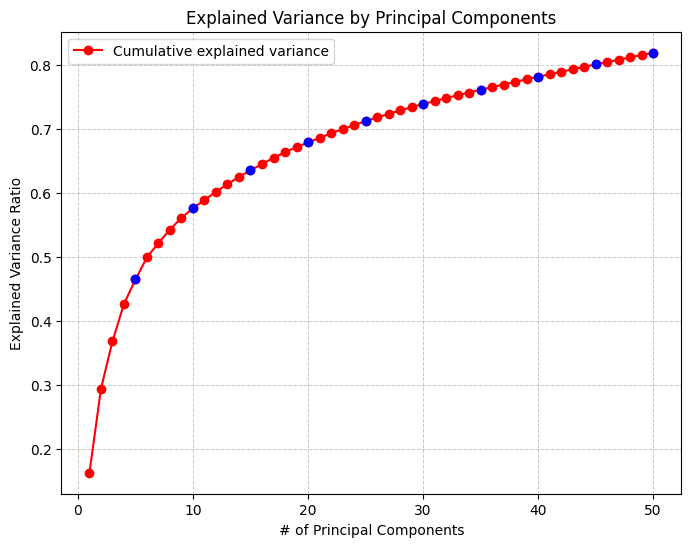

final kept columns:
    0.psd_alpha    0.psd_beta   0.psd_gamma  0.spectral_entropy_value  \
0  28903.253294  11045.919340  10097.405409                  4.682997   
1  24222.965505  15327.997675   7771.031388                  4.881996   
2  25489.561827  15637.863125   6656.028792                  4.980213   
3  30560.134074  12146.879633   8309.699314                  4.763782   
4   9059.280872  11891.181482  14946.075982                  4.568809   

   0.sample_entropy_value  0.delta_rel_power  0.theta_rel_power  \
0                0.000000           0.126007           0.113080   
1                0.000000           0.103916           0.113719   
2                0.000000           0.152932           0.145651   
3                2.197225           0.144180           0.167646   
4                2.251292           0.096144           0.094395   

   0.alpha_rel_power  0.beta_rel_power   1.psd_delta  ...  3.alpha_rel_power  \
0           0.198385          0.288060  31541.470105  ... 

In [31]:
df_M_preprocessed = perform_feature_selection(df_M, variance_threshold=0.8)

In [32]:
df_M_y = df_M.iloc[:, -1]
df_M_preprocessed = pd.concat([df_M_preprocessed, df_M_y], axis=1)
df_M_preprocessed.head()

,0.psd_alpha,0.psd_beta,0.psd_gamma,0.spectral_entropy_value,0.sample_entropy_value,0.delta_rel_power,0.theta_rel_power,0.alpha_rel_power,0.beta_rel_power,1.psd_delta,...,3.beta_rel_power,4.spectral_entropy_value,4.sample_entropy_value,4.delta_rel_power,4.theta_rel_power,4.alpha_rel_power,4.beta_rel_power,5.psd_theta,5.psd_alpha,Stress_level
0,28903.253294,11045.919340,10097.405409,4.682997,0.000000,0.126007,0.113080,0.198385,0.288060,31541.470105,...,0.286159,4.798258,1.011601,0.128433,0.089796,0.149600,0.272275,15538.407764,13767.001272,1
1,24222.965505,15327.997675,7771.031388,4.881996,0.000000,0.103916,0.113719,0.099169,0.406341,39936.522448,...,0.357124,4.644495,2.302585,0.048157,0.114016,0.068751,0.421122,15484.868142,6198.527169,1
2,25489.561827,15637.863125,6656.028792,4.980213,0.000000,0.152932,0.145651,0.148117,0.352012,64146.785166,...,0.440160,5.066317,0.000000,0.141043,0.134068,0.109486,0.345443,15736.213638,13617.609789,1
3,30560.134074,12146.879633,8309.699314,4.763782,2.197225,0.144180,0.167646,0.126172,0.229902,33907.780297,...,0.377961,5.132960,0.000000,0.073943,0.173494,0.065297,0.372234,18922.574257,8836.577200,1
4,9059.280872,11891.181482,14946.075982,4.568809,2.251292,0.096144,0.094395,0.037819,0.262839,37629.361928,...,0.175952,4.435181,0.000000,0.106252,0.068112,0.035404,0.232570,8578.423712,3019.109910,1


Number of principal components to keep 80.0 % of variance: 46


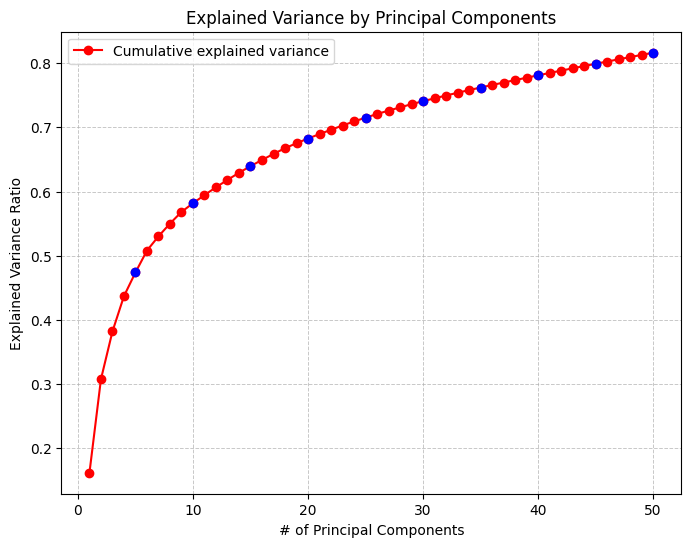

final kept columns:
    0.psd_delta  0.psd_gamma  0.spectral_entropy_value  \
0   9994.605340  1391.927018                  4.815256   
1  14145.852129  1267.961710                  4.694600   
2  10178.565631   756.718130                  4.504481   
3  16698.788741  1156.874710                  4.389518   
4   5514.739540   938.632292                  4.258969   

   0.sample_entropy_value  0.delta_rel_power  0.theta_rel_power  \
0                1.098612           0.170113           0.160691   
1                1.386294           0.208996           0.179670   
2                2.564949           0.090317           0.396408   
3                2.251292           0.235712           0.082317   
4                0.000000           0.054284           0.207531   

   0.alpha_rel_power  0.beta_rel_power   1.psd_delta   1.psd_theta  ...  \
0           0.170023          0.355683   9257.775317   7265.036422  ...   
1           0.160041          0.280880  10435.260425   3644.720023  ...   
2  

In [33]:
df_S_preprocessed = perform_feature_selection(df_S, variance_threshold=0.8)

In [34]:
df_S_y = df_S.iloc[:, -1]
df_S_preprocessed = pd.concat([df_S_preprocessed, df_S_y], axis=1)
df_S_preprocessed.head()

,0.psd_delta,0.psd_gamma,0.spectral_entropy_value,0.sample_entropy_value,0.delta_rel_power,0.theta_rel_power,0.alpha_rel_power,0.beta_rel_power,1.psd_delta,1.psd_theta,...,3.alpha_rel_power,3.beta_rel_power,4.psd_delta,4.psd_theta,4.psd_alpha,4.psd_beta,4.psd_gamma,4.spectral_entropy_value,4.sample_entropy_value,Stress_level
0,9994.605340,1391.927018,4.815256,1.098612,0.170113,0.160691,0.170023,0.355683,9257.775317,7265.036422,...,0.153701,0.297931,11962.079743,7616.719576,8555.264679,2759.863513,1367.442590,4.903859,0.000000,1
1,14145.852129,1267.961710,4.694600,1.386294,0.208996,0.179670,0.160041,0.280880,10435.260425,3644.720023,...,0.162207,0.392005,12246.281783,6463.806082,5523.576530,4268.471560,1328.496629,4.720588,1.945910,1
2,10178.565631,756.718130,4.504481,2.564949,0.090317,0.396408,0.183662,0.233491,4620.447414,10058.027260,...,0.195912,0.276737,7910.185855,18249.910520,7116.787168,4956.644722,686.523446,4.467537,2.079442,1
3,16698.788741,1156.874710,4.389518,2.251292,0.235712,0.082317,0.311588,0.210519,17008.405306,2634.528149,...,0.347522,0.247001,11628.322260,8135.949233,15869.530564,3122.330885,1096.519798,4.412611,0.000000,1
4,5514.739540,938.632292,4.258969,0.000000,0.054284,0.207531,0.382018,0.287536,5870.110121,9069.907815,...,0.334017,0.302305,6754.787865,9977.967308,11733.082895,3283.993904,761.640077,4.356629,1.386294,1


In [53]:
# # Train-test split (80-20)
# def split_data(X, y):
#     return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# X_A_train, X_A_test, y_A_train, y_A_test = split_data(X_A, y_A)
# X_M_train, X_M_test, y_M_train, y_M_test = split_data(X_M, y_M)
# X_S_train, X_S_test, y_S_train, y_S_test = split_data(X_S, y_S)

# Hyperparameter tuning with GridSearchCV and evaluation
def train_logistic_regression(df: pd.DataFrame):
    # Split into training for x and y
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True) 
    # print(y_train.head())
    # print(y_test.head())
    
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # regularization methods
        'class_weight': [None, 'balanced'],  # Adjust for class imbalance
        'max_iter': [50, 100, 150]
    }
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=StratifiedKFold(), scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Results:")
    print("Best Parameters:", grid_search.best_params_)
    # print(confusion_matrix(y_test, y_pred))
    # print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # ROC Curve
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve:')
    plt.legend(loc="lower right")
    plt.show()



c:\Users\sean\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sean\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Results:
Best Parameters: {'class_weight': 'balanced', 'max_iter': 150, 'penalty': 'l2'}
Accuracy: 0.555


c:\Users\sean\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


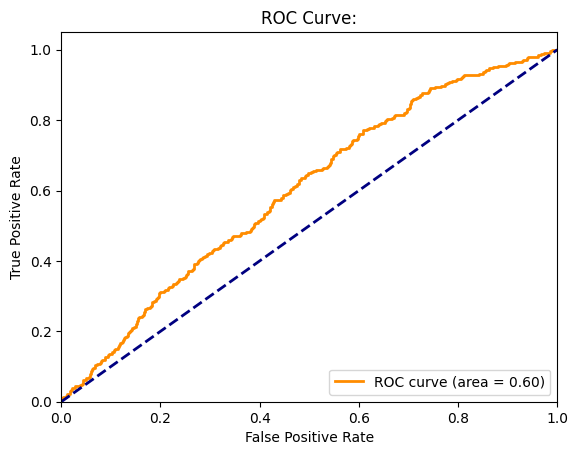

In [54]:
train_logistic_regression(df_A_preprocessed)